# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \theta & \dot{x} & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
from ilqr.cost import QRCost, FiniteDiffCost
from ilqr.mujoco_dynamics import MujocoDynamics
from ilqr.mujoco_controller import iLQR
from ilqr.examples.cartpole import CartpoleDynamics
from ilqr.dynamics import constrain

from scipy.optimize import approx_fprime

import mujoco_py
from mujoco_py import MjViewer
import os

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
xml_path = os.path.join('..', 'ilqr', 'xmls', 'inverted_pendulum.xml')
dynamics = MujocoDynamics(xml_path, frame_skip = 2)
print(dynamics.dt)


0.04


In [7]:
x_goal = np.array([0.0, 0.0, 0.0, 0.0])

# Instantenous state cost.
Q = np.eye(4)
Q[0, 0] = 10.0
Q[1, 1] = 10.0


# Terminal state cost.
Q_terminal = 100 * Q

# Instantaneous control cost.
R = 10 * np.eye(1)

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 100
x0 = np.array([0.0, np.pi - 1, 0.0, 0.0])
us_init = np.array([[-4.76751939e-01],
 [ 3.34490970e-01],
 [-3.99608551e-01],
 [ 8.41882163e-01],
 [-8.93302461e-01],
 [-3.57273055e-01],
 [-3.32158856e-01],
 [-4.82030121e-01],
 [-6.84388675e-01],
 [-4.26475287e-01],
 [-4.90913171e-01],
 [ 1.14754770e-01],
 [ 3.90275383e-01],
 [-4.36421243e-01],
 [ 5.57806778e-01],
 [ 7.83813923e-01],
 [-3.27778717e-01],
 [ 8.00582346e-01],
 [-8.49640982e-01],
 [-5.69222128e-01],
 [ 2.58447724e-01],
 [ 6.02857039e-01],
 [-6.11855326e-01],
 [ 7.00853348e-01],
 [-9.31090157e-01],
 [ 4.97665652e-01],
 [ 2.45721323e-01],
 [-1.92025996e-01],
 [ 2.72219728e-02],
 [ 7.95701514e-01],
 [-8.92320606e-01],
 [ 3.22802941e-02],
 [ 2.69562194e-01],
 [-1.46125346e-01],
 [-3.15934186e-02],
 [ 6.61809200e-01],
 [ 4.76622656e-01],
 [-9.78007260e-01],
 [ 5.73481914e-01],
 [-1.28208542e-02],
 [ 1.48147746e-01],
 [ 1.39421731e-04],
 [ 1.08812740e-01],
 [ 6.16007441e-01],
 [ 2.66982969e-01],
 [-2.09250070e-02],
 [ 6.04343953e-02],
 [ 4.14836049e-01],
 [-7.01346473e-01],
 [ 2.94563133e-01],
 [-3.07180590e-01],
 [ 6.53429823e-01],
 [ 3.87696411e-01],
 [-1.60361255e-01],
 [-7.91982930e-01],
 [ 3.04331662e-01],
 [-3.33057338e-01],
 [-1.45487867e-01],
 [-4.48293362e-01],
 [-4.56753222e-01],
 [-5.63113978e-02],
 [ 9.17106858e-01],
 [-7.79117478e-01],
 [-7.74944928e-01],
 [ 1.26081663e-01],
 [ 8.11397037e-02],
 [-6.58667412e-01],
 [ 9.01877119e-01],
 [-7.59017615e-01],
 [-6.54909707e-01],
 [-7.19152458e-01],
 [-8.23250291e-01],
 [-1.96576912e-01],
 [ 3.31076346e-01],
 [-9.59322994e-01],
 [ 6.61615691e-01],
 [-4.48940253e-01],
 [-4.10547311e-01],
 [-8.26340358e-01],
 [ 7.48939731e-01],
 [-8.83894866e-01],
 [ 4.12684469e-01],
 [-4.61578622e-01],
 [-8.29689676e-01],
 [-9.02561735e-01],
 [-2.44970624e-01],
 [ 2.86652487e-01],
 [-8.59512109e-01],
 [-5.89043961e-01],
 [ 6.21286175e-01],
 [-4.02464523e-01],
 [-7.80221770e-01],
 [-7.58513349e-01],
 [ 5.35469863e-01],
 [ 7.43535637e-01],
 [ 9.40814704e-01],
 [-9.31071558e-01],
 [-4.20465454e-01],
 [-1.28056017e-01],
 [-2.09487816e-01]])
ilqr = iLQR(dynamics, cost1, N)

In [9]:
t0 = time.time()
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)
print('\n\n\n\n\n')
print('time', time.time() - t0)

iteration 0 accepted 28533.592865501727 [-1.68990073  2.02240946  0.85810789 -7.06819606]
iteration 1 accepted 28337.937538114165 [-1.53735653  3.03662428  2.43844927 -3.97309874]
iteration 2 accepted 24748.234647566085 [-0.55953242  1.83833087  1.25904365 -7.39646503]
iteration 3 accepted 20097.037198549322 [ 0.27200891  2.4873016   0.338803   -1.33640821]
iteration 4 accepted 19157.283728264436 [ 0.51859316  1.50175424 -0.45248307 -6.0811531 ]
iteration 5 accepted 18565.31793294153 [ 0.22248588  2.34043776 -1.87457509 -3.35855588]
iteration 6 accepted 16029.634275939763 [ 0.45307076  2.18204627 -2.17138985  0.83296674]
iteration 7 accepted 14085.14030236678 [ 0.27259897  1.54854003 -2.16699145 -2.44762608]
iteration 8 accepted 13658.987366812007 [ 0.19234253  1.39107379 -2.00628328 -2.07015587]
iteration 9 accepted 13212.117549896715 [ 0.20840998  1.5048245  -1.79477607 -0.95674604]
iteration 10 accepted 13139.214921964773 [ 0.24369448  1.39268516 -1.68729136 -0.89800844]
iteration 1

iteration 94 accepted 7716.487233399928 [-0.06323781 -0.04850217  0.26199952  0.12224198]
iteration 95 accepted 7683.326093606722 [-0.07920903 -0.05584162  0.29586792  0.13686379]
iteration 96 accepted 7618.277799720331 [-0.00386565 -0.02474781  0.14353453  0.07276448]
iteration 97 accepted 7597.536810038626 [-0.0212658  -0.03361716  0.18705146  0.0915431 ]
iteration 98 accepted 7545.565937755192 [-0.01391924 -0.02996617  0.16740302  0.08291554]
iteration 99 accepted 7513.118356197385 [ 0.03652996 -0.0015917   0.0183343   0.01694999]
iteration 100 accepted 7471.168053977813 [-0.01323531 -0.02651176  0.14182541  0.07118279]
iteration 101 accepted 7438.53724775277 [-0.03245974 -0.03444613  0.18371369  0.08816299]
iteration 102 accepted 7422.218573773008 [-0.00611287 -0.02276452  0.12249175  0.0618817 ]
iteration 103 accepted 7371.410794135777 [-0.00433588 -0.02126638  0.11471916  0.05817058]
iteration 104 accepted 7350.06236418432 [-0.00106034 -0.01951425  0.10505189  0.0538625 ]
iterati

iteration 189 accepted 4766.5777293650135 [ 0.00344481  0.0026288  -0.01499655 -0.00691258]
iteration 190 accepted 4732.718562589993 [ 0.00378637  0.00338593 -0.01832816 -0.00861661]
iteration 191 accepted 4696.272831080322 [ 0.00399716  0.00364304 -0.01963943 -0.00925357]
iteration 192 accepted 4664.0860226573095 [ 0.00409953  0.00422214 -0.02193822 -0.01048151]
iteration 193 accepted 4630.085629307768 [ 0.00316242  0.00264266 -0.01467647 -0.00683996]
iteration 194 accepted 4615.357139535465 [ 0.00167913  0.00043692 -0.00426009 -0.00166695]
iteration 195 accepted 4575.416763452631 [ 0.00196082  0.0009079  -0.00644066 -0.00275915]
iteration 196 accepted 4541.451249795311 [ 0.00269136  0.0024157  -0.01314626 -0.00617197]
iteration 197 accepted 4513.803374284489 [ 0.00142024  0.0002051  -0.00302516 -0.00108386]
iteration 198 accepted 4490.058506231935 [ 0.00205396  0.00130643 -0.00810231 -0.00363299]
iteration 199 accepted 4477.625464860265 [ 0.00227539  0.00173594 -0.01003315 -0.0046113

iteration 280 accepted 2416.271617389119 [-8.14307844e-06  1.32214202e-05 -8.25565423e-05 -1.56969241e-05]
iteration 281 accepted 2413.953025581547 [-1.22733128e-05  1.21611535e-05 -7.08341715e-05 -1.10047160e-05]
iteration 282 accepted 2413.266641017449 [-1.39825995e-05  1.08821492e-05 -6.28404219e-05 -7.33500960e-06]
iteration 283 accepted 2412.7237295184327 [-1.48410278e-05  9.92179468e-06 -5.76635381e-05 -4.84970514e-06]
iteration 284 accepted 2412.487344120405 [-1.53038444e-05  9.25919031e-06 -5.43264717e-05 -3.21008117e-06]
iteration 285 accepted 2412.3150208491725 [-1.55256924e-05  8.78105527e-06 -5.21395800e-05 -2.09965994e-06]
iteration 286 accepted 2412.2243253372885 [-1.56879256e-05  8.46952342e-06 -5.06744434e-05 -1.36237506e-06]
iteration 287 accepted 2412.1605827874073 [-1.57460925e-05  8.24656920e-06 -4.97412289e-05 -8.72765503e-07]
iteration 288 accepted 2412.122751386001 [-1.58161126e-05  8.10301195e-06 -4.90738573e-05 -5.35416604e-07]
iteration 289 accepted 2412.09675

In [10]:
t = np.arange(N + 1) * dynamics.dt
x = xs[:, 0]
x_dot = xs[:, 2]
theta = np.unwrap(xs[:, 1])  # Makes for smoother plots.
theta_dot = xs[:, 3]

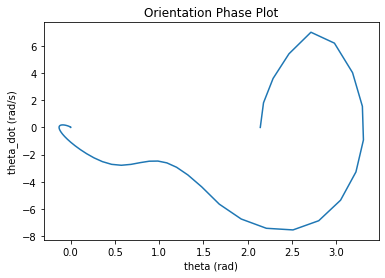

In [11]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

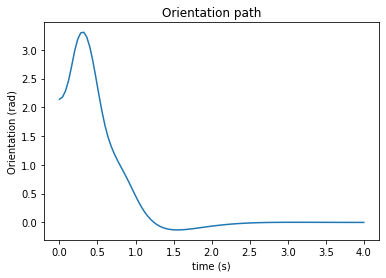

In [12]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

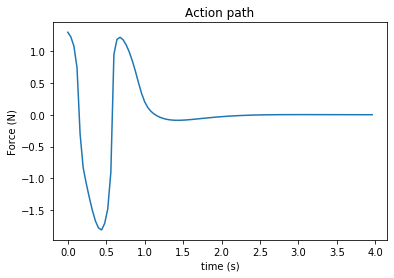

In [13]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

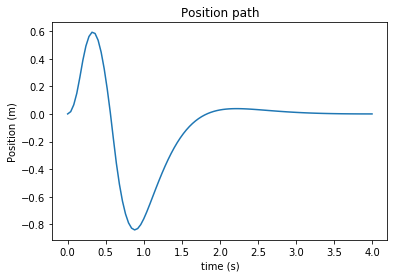

In [14]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

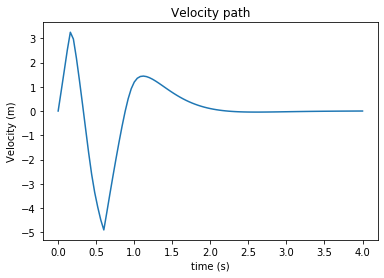

In [15]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

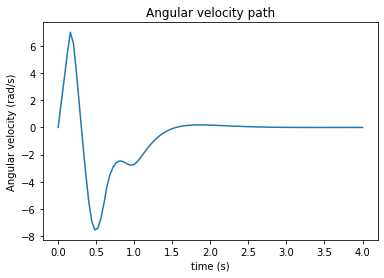

In [16]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

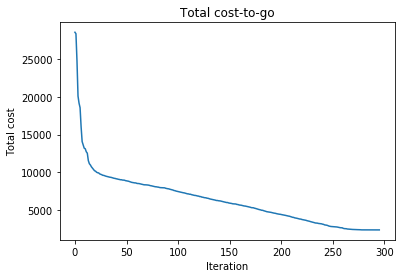

In [17]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

In [18]:
viewer = MjViewer(dynamics.sim)
dynamics.set_state(x0)
print(dynamics.get_state())
for i, u in enumerate(us):
    print (i, u)
    print(xs[i+1], dynamics.step(u))
    print('')
    viewer.render()

Creating window glfw
[0.         2.14159265 0.         0.        ]
0 [1.2954123]
[0.01648612 2.17799812 0.8261238  1.80991612] [0.01648612 2.17799812 0.8261238  1.80991612]

1 [1.22145354]
[0.06610861 2.2859009  1.66269425 3.59522005] [0.06610861 2.2859009  1.66269425 3.59522005]

2 [1.07506211]
[0.14936347 2.46553098 2.51094138 5.40721364] [0.14936347 2.46553098 2.51094138 5.40721364]

3 [0.7387762]
[0.26447713 2.71354692 3.2490645  6.99033839] [0.26447713 2.71354692 3.2490645  6.99033839]

4 [-0.30024743]
[0.38922628 2.97876657 2.96983832 6.18912305] [0.38922628 2.97876657 2.96983832 6.18912305]

5 [-0.82976403]
[0.49233513 3.18355358 2.17790613 4.02011554] [0.49233513 3.18355358 2.17790613 4.02011554]

6 [-1.07782073]
[0.56090672 3.29448857 1.25415348 1.54869117] [0.56090672 3.29448857 1.25415348 1.54869117]

7 [-1.29877755]
[ 0.59150908  3.30636364  0.28028613 -0.91909323] [ 0.59150908  3.30636364  0.28028613 -0.91909323]

8 [-1.5025142]
[ 0.58265546  3.2217453  -0.71908426 -3.2683

72 [0.00188848]
[ 0.01375673  0.00140922 -0.03358804  0.00783387] [ 0.01375673  0.00140922 -0.03358804  0.00783387]

73 [0.00199388]
[ 0.01245307  0.00167768 -0.03160509  0.00567811] [ 0.01245307  0.00167768 -0.03160509  0.00567811]

74 [0.00205937]
[ 0.01122906  0.00186628 -0.0296034   0.00382049] [ 0.01122906  0.00186628 -0.0296034   0.00382049]

75 [0.00209094]
[ 0.01008494  0.00198637 -0.0276087   0.00223456] [ 0.01008494  0.00198637 -0.0276087   0.00223456]

76 [0.00209401]
[ 0.00902001  0.00204827 -0.02564223  0.00089504] [ 0.00902001  0.00204827 -0.02564223  0.00089504]

77 [0.00207341]
[ 0.0080328   0.00206129 -0.02372125 -0.0002221 ] [ 0.0080328   0.00206129 -0.02372125 -0.0002221 ]

78 [0.00203349]
[ 0.00712122  0.00203386 -0.02185948 -0.00113953] [ 0.00712122  0.00203386 -0.02185948 -0.00113953]

79 [0.00197811]
[ 0.0062827   0.00197348 -0.02006753 -0.00187849] [ 0.0062827   0.00197348 -0.02006753 -0.00187849]

80 [0.00191067]
[ 0.00551429  0.00188688 -0.01835327 -0.00245875

In [20]:
print(dynamics.get_state())
print(xs[-1])

[-1.58605850e-05  7.83998166e-06 -4.80119334e-05  3.02314566e-08]
[-1.58605850e-05  7.83998166e-06 -4.80119334e-05  3.02314566e-08]


In [7]:
#FOR TESTING PURPOSES

In [13]:
dynamics1 = MujocoDynamics(xml_path, frame_skip = 2, bounds = np.array([[-1, 1]]), x_eps = np.sqrt(np.finfo(float).eps), u_eps = np.sqrt(np.finfo(float).eps))
dynamics2 = CartpoleDynamics(0.04)

In [37]:
state = np.array([0.0,0.0,0.0,0.0])
action = np.array([-0.37])

In [44]:
count = 0
def helper(x, u):
    global count
    count += 1
    dynamics1.set_state(x)
    return dynamics1.step(u)

f_x = np.vstack([
            approx_fprime(state, lambda x: helper(x, action)[m], 1.5e-8)
            for m in range(dynamics1.state_size)
        ])
print(f_x)
print(count)

[[ 1.0000 -0.0014  0.0399  0.0001]
 [ 0.0000  1.0142  0.0002  0.0386]
 [ 0.0000 -0.0921  0.9963  0.0063]
 [ 0.0000  0.9015  0.0085  0.9390]]
20


In [45]:
count = 0

dynamics1.set_state(state)
count += 1
dynamics1.step(action)
center = dynamics1.get_state()
f_x = np.empty((dynamics1.state_size, dynamics1.state_size))

dynamics1.sim.data.ctrl[:] = dynamics1.constrain(action)
for i in range(dynamics1.sim.model.nq):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    dynamics1.sim.data.qpos[i] += dynamics1.x_eps
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.x_eps
    f_x[:, i] = deriv

for i in range(dynamics1.sim.model.nv):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    dynamics1.sim.data.qvel[i] += dynamics1.x_eps
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.x_eps
    f_x[:, dynamics1.sim.model.nq + i] = deriv
print(f_x)
print(count)

[[ 1.0000 -0.0014  0.0399  0.0001]
 [ 0.0000  1.0142  0.0002  0.0386]
 [ 0.0000 -0.0921  0.9963  0.0063]
 [ 0.0000  0.9015  0.0085  0.9390]]
5


In [42]:
count = 0
def helper(x, u):
    global count
    count += 1
    dynamics1.set_state(x)
    return dynamics1.step(u)

f_u = np.vstack([
            approx_fprime(action, lambda u: helper(state, u)[m], dynamics1.u_eps)
            for m in range(dynamics1.state_size)
        ])

print(f_u)
print(count)

[[ 0.0064]
 [-0.0151]
 [ 0.3202]
 [-0.7445]]
8


In [47]:
count = 0

dynamics1.set_state(state)
count += 1
dynamics1.step(action)
center = dynamics1.get_state()
f_u = np.empty((dynamics1.state_size, dynamics1.action_size))


for i in range(dynamics1.action_size):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    action[i] += dynamics1.u_eps
    dynamics1.sim.data.ctrl[:] = dynamics1.constrain(action)
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.u_eps
    f_u[:, i] = deriv

    action[i] -= dynamics1.u_eps
print(f_u)
print(count)

[[ 0.0064]
 [-0.0151]
 [ 0.3202]
 [-0.7445]]
2
